In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import logsumexp
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
#from Homework2 import *

In [3]:
def extractdata(classification):
    """
        Extracts the  data given the path 
    """ 
    data  = pd.read_csv(classification,sep = ' ', header=None, engine='python')
    X = data.as_matrix()[:,0:2]
    return X

In [4]:
U = extractdata('classification_data_HWK2/EMGaussian.data')
Utest = extractdata('classification_data_HWK2/EMGaussian.test')

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [5]:
T,d = np.shape(U)

In [6]:
# gaussian density
def gauss(x,mu,S):
    rv = multivariate_normal(mu,S)
    return rv.pdf(x)

# gaussian density in log scaleù^m
def gauss_log(x,mu,S):
    rv = multivariate_normal(mu,S)
    return rv.logpdf(x)



## 1

In [7]:
def alpha_log(U,pi1,A,mus,sigmas):
    """
    Computes the alpha messages recursively
    Parameters
    ----------
    U : Array of observations
    pi1 : Initial distribution of the markov chain
    A : Transition matrix of the Markov Chain
    mus,sigmas : Parameters of the emission gaussians
    Returns
    -------
    logalphas : Array of alpha messages in logscale
    """
    T = np.shape(U)[0] # Number of observations
    K = np.shape(pi1)[0] # Number of classes
    A_log = np.log(A) # Transition matrix in logscale

    # Initialization
    loga = np.log(pi1) + np.array([gauss_log(U[0],mus[i],sigmas[i]) for i in range(K)])
    logalphas = np.zeros((T,K))
    logalphas[0] = loga
    # Alpha recursions
    for t in range(1,T):
        for i in range(K):
            log_ems = gauss_log(U[t],mus[i],sigmas[i])
            logalphas[t][i] = log_ems + logsumexp(A_log[i]+logalphas[t-1])
    return logalphas
        
def beta_log(U,pi1,A,mus,sigmas):
    """
    Computes the beta messages recursively
    Parameters
    ----------
    U : Array of observations
    pi1 : Initial distribution of the markov chain
    A : Transition matrix of the Markov Chain
    mus,sigmas : Parameters of the emission gaussians
    Returns
    -------
    logbetas : Array of beta messages in logscale
    """
    T = np.shape(U)[0] # Number of observations
    K = np.shape(pi1)[0] # Number of classes
    A_log = np.log(A) # Transition matrix in logscale
    # Initialization
    logb = np.zeros(np.shape(pi1))
    logbetas = np.zeros((T,K))
    logbetas[T-1] = logb
    
    # Beta recursions
    for t in range(1,T):
        for j in range(K):
            log_ems = np.array([gauss_log(U[T-t],mus[i],sigmas[i]) for i in range(K)])
            logbetas[T-t-1][j] = logsumexp(A_log[:,j] + log_ems + logbetas[T-t])
    return logbetas

## 2 

In [8]:
# Initial distribution
pi1 = 0.25*np.ones(4)
# Transition matrix
A = np.array( [[ 1./2,  1./6, 1./6, 1./6],
               [ 1./6, 1./2, 1./6, 1./6],
               [ 1./6, 1./6, 1./2, 1./6],
               [ 1./6, 1./6, 1./6, 1./2]])

# Means and Covariance matrices obtained in the previous homework for the emission probabilities
mus = np.array([[-3.03086617, -3.50058694],
       [ 3.98609282,  4.03525452],
       [ 3.79801919, -3.70723762],
       [-2.06471094,  4.18252167]])

sigmas = np.array([[[  6.36052388,   6.18082784],
        [  6.18082784,   6.32738957]],

       [[  0.20812237,   0.22814132],
        [  0.22814132,  11.11142786]],

       [[  0.88553325,   0.05396892],
        [  0.05396892,   2.05232288]],

       [[  2.8042089 ,   0.22192863],
        [  0.22192863,   2.6946592 ]]])


In [9]:
def smooth(U,pi1,A,mus,sigmas):
    """
    Computes the probabilities for each class of the t-th hidden variable qt in log scale
    """
    T,d = np.shape(U)
    K = np.shape(pi1)[0]
    log_ps = np.zeros((T,K))
    log_alphas = alpha_log(U,pi1,A,mus,sigmas)
    log_betas = beta_log(U,pi1,A,mus,sigmas)
    tmp = logsumexp(log_alphas + log_betas,axis=1) # Partial likelihood of the observations
    for t in range(T):
        for i in range(K):
            log_ps[t][i] = log_alphas[t][i] + log_betas[t][i] - tmp[i]
    return log_ps

In [10]:
b=beta_log(U,pi1,A,mus,sigmas)
a=alpha_log(U,pi1,A,mus,sigmas)

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


In [11]:
ps = np.exp(smooth(U,pi1,A,mus,sigmas))

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  # Remove the CWD from sys.path while we load stuff.


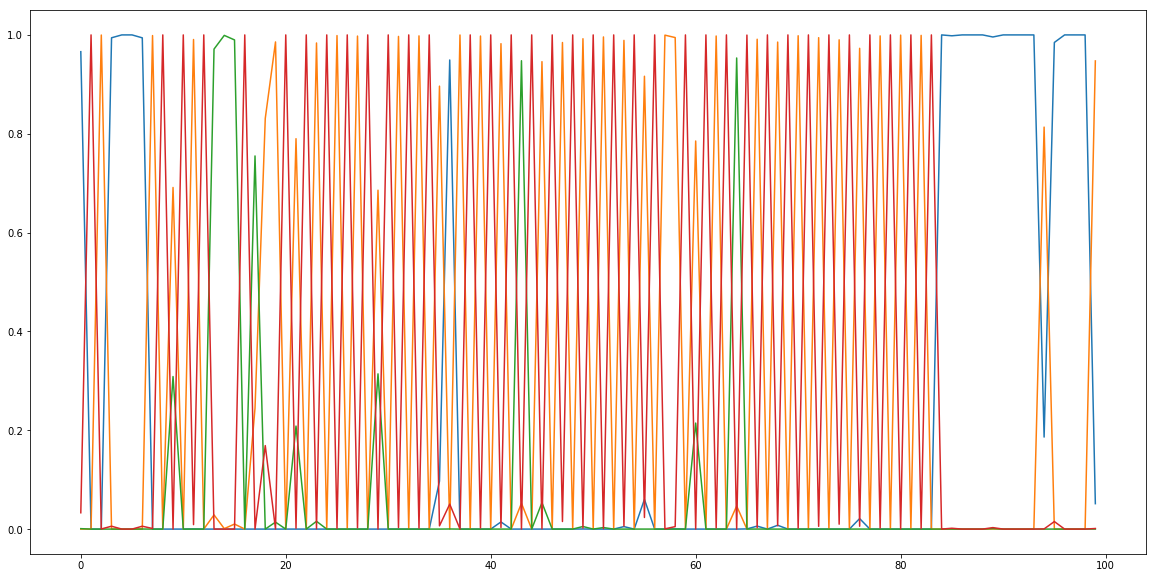

In [12]:
plt.figure(figsize = (20,10))
plt.plot(range(100),ps[:100])
plt.show()

## 3


On note  $\theta = (\pi_1,A,(\mu_i,\Sigma_i)_{i=1,...,4})$ les paramètres du modèle, et $f_{\mu,\Sigma}$ la densité de la loi normale de paramètres $(\mu,\Sigma)$.


Le modèle de Markov Caché admet la fonction de log-vraisemblance suivante:
$$ 
L(q_1,...,q_T,\bar{u_1},...,\bar{u_T}) = \sum_{i=1}^4 \delta(q_1 = i) log((\pi_{1})_i) + \sum_{i=1}^4 \sum_{j=1}^4 \sum_{t=1}^{T-1} \delta(q_{t+1} = i,q_t = j) log(A_{ij}) + \sum_{i=1}^4 \sum_{t=1}^T log(f_{\mu_i,\Sigma_i}(\bar{u_t})) \delta(q_t = i)$$


$\pi_1, A$ sont l'état initial et la matrice de transition de la chaîne de Markov du modèle.
$(\mu_i,\Sigma_i)$ sont les paramètres des probabilités d'émission (gaussiennes).

Supposons qu'à l'étape $k-1$ de l'EM on ait estimé des paramètres $\theta^{k-1} = (\pi_1^{(k-1)},A^{(k-1)},(\mu_i^{k-1},\Sigma_i^{k-1})_{i=1,...,4})$

L'algorithme est alors le suivant:

Etape E:
Calculer la vraisemblance des observations : $$p(\bar{u_1},...,\bar{u_T}) = \sum_{i=1}^4\alpha_t(i) \beta_t(i)$$ 
(Pour t= 1 par exemple)

Pour tout $i=1,...,4, t = 1,...,T$, calculer :

$$\tau_i^t \triangleq \mathbb{E}[\delta(q_t = i)|\bar{q},\theta^{k-1}] = p(q_t = i||\bar{u},\theta^{k-1}) \\ = \frac{\alpha_t(i) \beta_t(i)}{p(\bar{u_1},...,\bar{u_T})} $$

Si $t<T$:
$$\nu_{ij}^t \triangleq \mathbb{E}[\delta(q_{t
+1}= i, q_t = j)|\bar{u},\theta^{k-1}] = p(q_{t
+1}= i,q_t = j|\bar{u},\theta^{k-1}) \\ = \frac{\alpha_t(j) \beta_{t+1}(i)A_{ij}^{(k-1)}f_{\mu_i^{k-1},\Sigma_i^{k-1}}(\bar{u_{t+1}})}{p(\bar{u_1},...,\bar{u_T})} $$

Etape M:

Pour mettre à jour l'estimateur theta^k , on doit maximiser par rapport à $\theta = (\pi_1,A,(\mu_i,\Sigma_i)_{i=1,...,4})$ la fonction suivante:
$$ 
Q(\theta,\theta^{k-1}) = \sum_{i=1}^4 \tau_i^1 log((\pi_{1})_i) + \sum_{i=1}^4 \sum_{j=1}^4 \sum_{t=1}^{T-1} \nu_{ij}^t log(A_{ij}) + \sum_{i=1}^4 \sum_{t=1}^T log(f_{\mu_i,\Sigma_i}(\bar{q_t})) \tau_i^t$$

sous les contraintes :
$$\sum_{i=1}^4 (\pi_1)_i = 1$$
$$\forall j = 1,...,4, \sum_{i=1}^4 A_{ij} = 1
$$

On obtient alors les formules de mise à jour suivantes :
$$ (\pi_1)_i = \frac{\tau_i^1}{\sum_{j=1}^4 \tau_j^1}$$
$$ A_{ij} = \frac{\sum_{t=1}^T \nu_{ij}^t}{\sum_{t=1}^T \sum_{i=1}^4\nu_{ij}^t}$$
$$ \mu_i = \frac{\sum_{t=1}^T \tau_i^t \bar{q_t}}{\sum_{t=1}^T \tau_i^t}$$
$$ \Sigma_i = \frac{\sum_{t=1}^T \tau_i^t (\bar{q_t}-\mu_i)(\bar{q_t}-\mu_i)^T}{\sum_{t=1}^T \tau_i^t}$$

## 4

In [13]:
def plot_contour(U,mus,sigmas,colors,title):
    """
    Plots the gaussians with parameters stored in the arrays mus and sigmas
    Parameters
    ----------
    U : Observations
    mus,sigmas : parameters of the emission gaussians
    title : title of the plot
    """
    plt.scatter(U[:,0],U[:,1],c=colors,cmap = 'rainbow')
    K = np.shape(mus)[0]
    mx, maxx = np.min(U[:, 0]), np.max(U[:, 0])
    my, maxy = np.min(U[:, 1]), np.max(U[:, 1])
    xs = np.linspace(mx, maxx, 400)
    ys = np.linspace(my, maxy, 400)
    x, y = np.meshgrid(xs, ys)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    cl = ['r','g','b','y']
    for i in range(K):
        plt.contour(x, y, multivariate_normal(mus[i] , sigmas[i]).pdf(pos),colors = cl[i] )
    plt.title(title)
    plt.show()
    

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarn

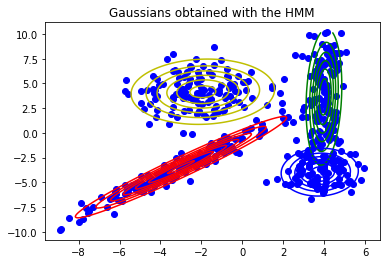

In [14]:
def E_HMM(u,la,lb,A,mus,sigmas):
    """
    Performs the E-step of the EM algorithm on the Hidden markov model
    Parameters
    ----------
    U : Observations
    la : alpha messages in log scale
    lb : beta messages in log scale
    pi1,A,mus,sigmas : current parameters
    Returns
    -------
    tau : Marginal posterior probabilities for each hidden variable and classe
    nu : Joint probabilities of adjacent nodes for each couple of adjacent hidden variables and classes
    """
    T,d = np.shape(U)
    K = np.shape(A)[1]
    
    # Likelihood of the observations
    tmp = logsumexp(la + lb,axis=1)

    # Compute marginal posterior probabilities
    log_tau = np.zeros((T,K))
    for t in range(T):
        for i in range(K):
            log_tau[t][i] = la[t][i] + lb[t][i] - tmp[i]
    
    # Compute joint posterior probabilities
    A_log = np.log(A)    
    log_nu = np.zeros((T-1,K,K))
    for t in range(T-1):
        for i in range(K):
            for j in range(K):
                log_nu[t][i][j] = la[t][j] + lb[t+1][i] + A_log[i][j] + gauss_log(U[t+1],mus[i],sigmas[i]) - tmp[i]
                
    return np.exp(log_tau),np.exp(log_nu)

def M_HMM(U,tau,nu):
    """
    Performs the M-step of the EM on the Hidden markov model
    Parameters
    ----------
    U : array of shape 2 containing the observations     
    tau : marginal probabilities computed at the E step in log scale
    nu : joint probabilities computed at the E step in log scale
    Returns
    -------
    pi1 : The updated initial distribution
    A : The updated 4*4 transition matrix 
    mus : updated means
    sigmas : Array of shape(4,2,2) containing the updated covariance matrices
    """
    T,K = np.shape(tau)
    pi1 = tau[1]
    A = np.sum(nu,axis = 0)/np.sum(nu,axis = (0,1))
    
    mus = np.zeros((K,2))
    for i in range(K):
        mus[i] = np.dot(tau[:,i].T,U)/np.sum(tau[:,i])
    
    sigmas = np.zeros((K,2,2))
    for i in range(K):
        for t in range(T):
            sigmas[i] += tau[t][i]*np.outer(U[t]-mus[i],U[t]-mus[i])
        sigmas[i]/=np.sum(tau[:,i])
        
    return pi1,A,mus,sigmas
    
    
def HMM(U,Utest,pi1_0,A0,mus0,sigmas0,Niter):
    """
    Computes the parameters of the Hidden Markov model with gaussian emision probabilities,
    using the EM algorithm
    """
    pi1 = pi1_0
    A = A0
    mus = mus0
    sigmas = sigmas0
    log_l = np.zeros(Niter) #  log likelihoods on training set
    log_l_test = np.zeros(Niter) # log likelihoods on test set
    for i in range(Niter):
        # E step
        la = alpha_log(U,pi1,A,mus,sigmas) # Alpha messages in log scale
        lb = beta_log(U,pi1,A,mus,sigmas) # Beta messages in log scale
        la_test = alpha_log(Utest,pi1,A,mus,sigmas)
        lb_test = beta_log(Utest,pi1,A,mus,sigmas)
        log_l[i] = (logsumexp(la+lb,axis=1))[0]
        log_l_test[i] = (logsumexp(la_test+lb_test,axis=1))[0]
        tau, nu = E_HMM(U,la,lb,A,mus,sigmas)
        # M step
        pi1,A,mus,sigmas = M_HMM(U,tau,nu)

    return pi1,A,mus,sigmas,log_l,log_l_test

# Initial distribution
pi1 = 0.25*np.ones(4)
# Transition matrix
A = np.array( [[ 1./2,  1./6, 1./6, 1./6],
               [ 1./6, 1./2, 1./6, 1./6],
               [ 1./6, 1./6, 1./2, 1./6],
               [ 1./6, 1./6, 1./6, 1./2]])

# Means and Covariance matrices obtained in the previous homework for the emission probabilities
mus = np.array([[-3.03086617, -3.50058694],
       [ 3.98609282,  4.03525452],
       [ 3.79801919, -3.70723762],
       [-2.06471094,  4.18252167]])

sigmas = np.array([[[  6.36052388,   6.18082784],
        [  6.18082784,   6.32738957]],

       [[  0.20812237,   0.22814132],
        [  0.22814132,  11.11142786]],

       [[  0.88553325,   0.05396892],
        [  0.05396892,   2.05232288]],

       [[  2.8042089 ,   0.22192863],
        [  0.22192863,   2.6946592 ]]])

U = extractdata('classification_data_HWK2/EMGaussian.data')
Utest = extractdata('classification_data_HWK2/EMGaussian.test')
pi1,A,mus,sigmas,logL_HMM,logL_HMM_test = HMM(U,Utest,pi1,A,mus,sigmas,20)
plot_contour(U,mus,sigmas,colors = 'b',title = 'Gaussians obtained with the HMM')


## 5

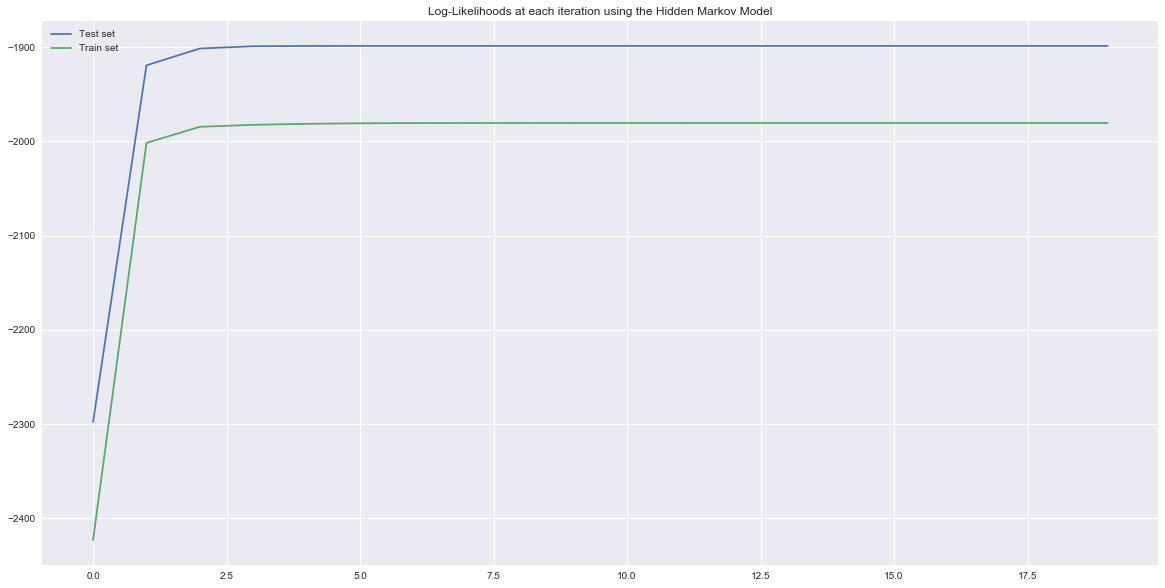

In [15]:
plt.figure(figsize = (20,10))
plt.plot(logL_HMM,label = 'Test set')
plt.plot(logL_HMM_test,label = 'Train set')
plt.legend()
plt.title('Log-Likelihoods at each iteration using the Hidden Markov Model')
plt.show()

In [16]:
def E_GMM(U,pi,mus,sigmas):
    """
    Performs the Expectation step of the EM for a Gaussian Mixture Model
    Parameters
    ----------
    pi : Current parameters for the class probabilities
    mus, sigmas : Current means and covariance matrices for each class
    Returns
    -------
    tau : matrix of posterior probabilities. 
            tau[t][j] is the posterior probability of the class j given the t-th observation
    """
    T,d = np.shape(U)
    K = np.shape(pi)[0]
    tau = np.zeros((T,K))
    for t in range(T):
        for j in range(K):
            tau[t][j] = pi[j]*gauss(U[t],mus[j],sigmas[j])
        tau[t]/=np.sum(tau[t])
    return tau

def M_GMM(U,tau):
    """
    Performs the Maximization step of the EM for a Gaussian Mixture Model
    Parameters
    ----------
    U : Observations
    tau : matrix of coefficients computed at the E step
    Returns
    -------
    pi : updated multinomial parameters of the hidden variable
    mus : updated means of the gaussians for each class 
    sigmas : updated covariance matrices of the gaussians for each class
    """
    T,d = np.shape(U)
    K = np.shape(tau)[1]
    
    pi = np.zeros(4)
    mus = np.zeros((4,2))
    sigmas = np.zeros((4,2,2))
    for j in range(K):
        # Update multivariate parameters
        pi[j] = np.mean(tau[:,j])
        # Update means
        mus[j] = np.dot(tau[:,j],U)/np.sum(tau[:,j])
        # Update covariance matrices
        for t in range(T):  
            sigmas[j] += tau[t][j]*np.outer(U[t]-mus[j],U[t]-mus[j])
        sigmas[j]/= np.sum(tau[:,j])
    return pi,mus,sigmas

def GMM(U,Utest,pi0,mus0,sigmas0,Niter):
    """
    Computes the parameters of a Gaussian mixture model using EM algorithm
    Parameters
    ----------
        X : Observations
        K : number of classes
        Niter : number of iterations
        log_l : Array containing the likelihood at each iteration


    Returns
    ------- 
        mu : Array containing the means of each class
        sigma : Array containing the standard deviations of each class
    """
    
    n,d = np.shape(U)
    K = np.shape(pi0)[0]
    #Initialization
                
    pi = pi0
    mus = mus0
    sigmas = sigmas0
    logLs = np.zeros(Niter)
    logLsTest = np.zeros(Niter)
    #EM Loop
    for i in range(Niter):
        # E-step
        tau = E_GMM(U,pi,mus,sigmas)
        # M-step
        pi, mus, sigmas = M_GMM(U,tau)
        # Compute log likelihoods
        l = log_L(U,tau,pi,mus,sigmas)
        ltest = log_L(Utest,tau,pi,mus,sigmas)
        logLs[i] = l
        logLsTest[i] = ltest
    return pi,mus,sigmas,logLs,logLsTest

def log_L(data,tau,pi,mus,sigmas):
    """
    Computes the log-likelihood of the observations X given the coefficents tau, and the estimated parameters pi,mu,sigmas
    """
    T,d = np.shape(data)
    K = np.shape(tau)[1]
    res = 0
    for t in range(T):
        tmp1 = np.sum([pi[j]*gauss(data[t],mus[j],sigmas[j]) for j in range(K)])
        res += np.log(tmp1)
            
        
    return res



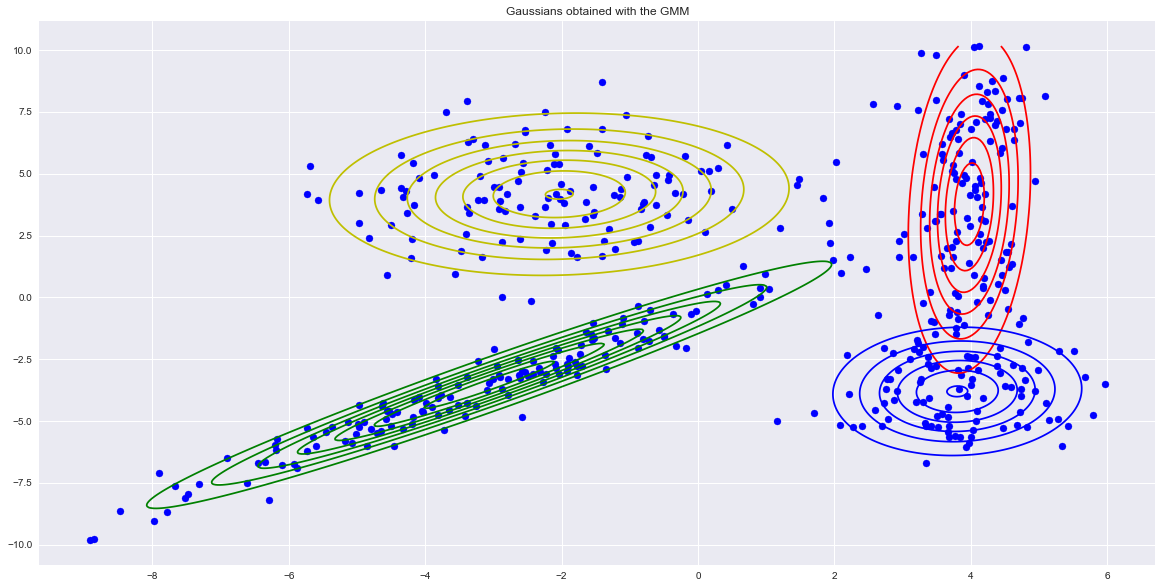

In [25]:
plt.figure(figsize = (20,10))

pi0 = np.ones(4)*0.25
mus0 = np.random.rand(4,2)
sigmas0 = np.zeros((4,2,2))
for i in range(4):
    sigmas0[i] = np.identity(2)
    
U = extractdata('classification_data_HWK2/EMGaussian.data')
Utest = extractdata('classification_data_HWK2/EMGaussian.test')
pi,mus,sigmas,logL_GMM,logL_GMM_test = GMM(U,Utest,pi0,mus0,sigmas0,50)
plot_contour(U,mus,sigmas,'b','Gaussians obtained with the GMM')



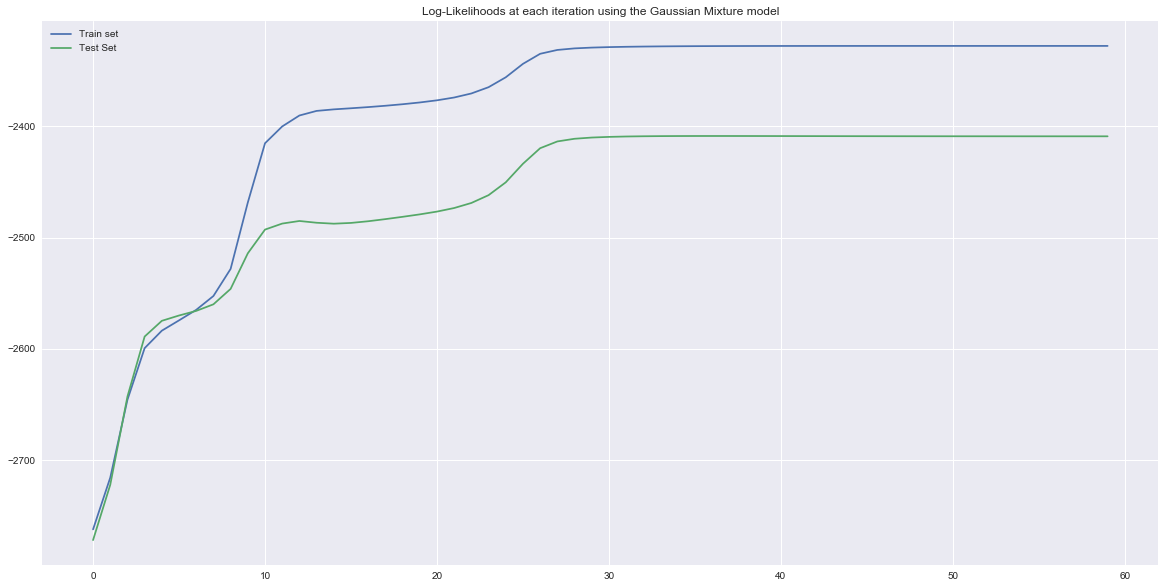

In [24]:
plt.figure(figsize = (20,10))
plt.plot(range(np.shape(logL_GMM)[0]),logL_GMM,label='Train set')
plt.plot(range(np.shape(logL_GMM_test)[0]),logL_GMM_test,label='Test Set')
plt.legend()
plt.title('Log-Likelihoods at each iteration using the Gaussian Mixture model')
plt.show()

In [ ]:
print('Log-vraisemblances du GMM sur l\'ensemble d\'entraînement:',logL_GMM )
print('Log-vraisemblances du HMM sur l\'ensemble d\'entraînement:',logL_HMM )
print('Log-vraisemblances du GMM sur l\'ensemble de test:',logL_GMM_test )
print('Log-vraisemblances du HMM sur l\'ensemble de test:',logL_HMM_test )

Le Modèle HMM est dans ce cas l'analogue du GMM, où la seule différence est que les variables cachées forment une chaîne de Markov au lieu d'être indépendantes. L'hypothèse que les variables cachées soient liées entre elles est plus réaliste dans de nombreux cas issus de la réalité (NLP, Séquençage adn, reconnaissance de la parole ,...), et le GMM permet d'encoder de l'information supplémentaire issue des observations, notemment dans la matrice de transition $A$. Cela explique la différence des vraisemblances entre les deux modèles. Dans le GMM on voit qu'il y a un problème de généralisation.

## 7

On cherche à calculer la séquence de variables cachées la plus vraisemblable conditionnellement aux observations, c'es-à-dire $$argmax_q(p(q_1,...,q_T|\bar{u_1},...,\bar{u_T})$$


Pour cela on utilise le fait que la loi jointe du modèle de Markov Caché se factorise de la manière suivante : $$p(q_1,...,q_T,u_1,...,u_T) = p(q_1)\prod_{t=1}^{T-1} p(q_{t+1}|q_t) \prod_{t=1}^T p(u_t|q_t)$$

Donc  $$argmax_q(p(q_1,...,q_T,u_1,...,u_T)) = argmax_{q_T}(p(u_T|q_T) argmax_{q_1,...,q_{T-1}} p(q_1)\prod_{t=2}^{T-1} p(q_{t+1}|q_t) \prod_{t=1}^ p(u_t|q_t)) $$

L'algorithme de Viterbi dans notre cas est le suivant:

On initialise la séquence par $$\alpha_{0 \rightarrow 1}(q_1) = argmax_{q_1} p(q_1) p(\bar{u_1}|q_1)$$

On définit le message alpha de t vers t+1 par $$\alpha_{t\rightarrow t+1}(q_{t+1}) = p(\bar{u_{t+1}}|q_{t+1}) argmax_{q_t} p(q_{t+1}|q_t)\alpha_{t-1\rightarrow t}(q_t) $$

La séquence la plus vraisemblable sera obtenue en conservant pour chaque observation t l'indice de la classe la plus vraisemblable.

## 8

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/pyth

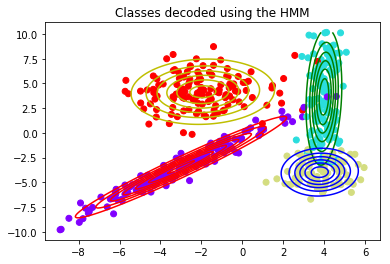

In [16]:
#from Homework2 import plot2DGMM
#define alpha recursion
def map_propagation(data, A, cov, mean, p0):
    """
    Computes the most likely sequence recursively using the Viterbi algorithm
    Parameters
    ----------
    data : Array of observations
    A : Transition matrix of the Markov Chain
    mus,sigmas : Parameters of the emission gaussians
    pi1 : Initial distribution of the markov chain

    Returns
    -------
    sequence : Most likely sequence
    """
    #initialization phase
    n = np.shape(A)[0]
    t = np.shape(data)[0]
    #al = (1./n)*np.ones([n,1])
    al =  np.reshape(p0,[n,1])
    #write coefficient in log scale
    al = np.log(al) 
    factors = [gauss_log(data[0],mean[i],cov[i]) for i in range(n)]
    al += np.reshape(factors,[n,1])
    Alog = np.log(A)
    previous = np.reshape(np.zeros(4),[4,1])
    
    #dynamic extansion of alpha
    
    for k in range(1,t):
        old = np.reshape(al[:,-1],[1,n])
        factors = [gauss_log(data[k],mean[i],cov[i]) for i in range(n)]
        factors = np.reshape(factors,[n,1])
        
        tmp = Alog + old +factors 
        new = np.reshape(np.max(tmp,1),[n,1])
        prev = np.where(tmp == new)[1]
        prev = np.reshape(prev,[n,1])
        al = np.c_[al, new]
        previous = np.c_[previous, prev]
    
    previous = previous[:,1:]
    # construct the sequence with the highest probability
    lab = np.zeros(t)
    lab[t-1] = np.where(al[:,-1]==max(al[:,-1]))[0][0]
    for k in range(2,t+1):
        lab[-k]= previous[int(lab[1-k]),1-k]
        
    return lab 

pi1,A,mus,sigmas,logL_HMM,logL_test_HMM = HMM(U,Utest,pi1,A,mus,sigmas,20)
lab = map_propagation(U, A, sigmas, mus, pi1)
plot_contour(U,mus,sigmas,lab,title = 'Classes decoded using the HMM')


## 9

In [ ]:
pi1,A,mus,sigmas,logL_HMM,logL_test_HMM = HMM(U,Utest,pi1,A,mus,sigmas,20)

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/Users/raphaelromero/miniconda3/lib/pyth

In [ ]:
logps = smooth(Utest,pi1,A,mus,sigmas)
ps = np.exp(logps)
plt.figure(figsize = (20,10))

plt.plot(range(100),ps[:100])
plt.title('Probabilities for each class and each observation of the test set')
plt.show()

## 10

In [ ]:
plt.figure(figsize = (20,10))
plt.scatter(range(100),np.argmax(ps,axis=1)[:100])
plt.title('Most likely class for each observation of the test set')
plt.show()


## 11

In [ ]:
lab = map_propagation(Utest, A, sigmas, mus, pi1)
plt.figure(figsize = (20,10))
plt.scatter(range(100),lab[:100])
plt.title('Most likely sequence computed using the Viterbi algorithm')
plt.show()

On voit que en passant par les probabilités marginales ou par l'algorithme de Viterbi on obtient la même séquence à permutation des classes près. 

## 12

Lorsque le nombre d'états n'est pas connu, on pourrait procéder de la même manière que pour le GMM, en optimisant un critère, par exemple l'AIC-BIC. Ce critère contient un terme favorisant la vraisemblance du modèle et un autre pénalisant le nombre de paramètres libres du modèle, et donc favorisant sa parcimonie.
